In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import all
import tarfile, os, torch
from torchsummary import summary

import random as rd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from fnmatch import fnmatch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Define the path to the zipped folder in your Google Drive
tar_file_path = '/content/drive/MyDrive/RNAStralign.tar.gz' #Change!

# Define the folder where you want to unzip the files (in-memory)
extracted_folder = '/content/sequences' #Change name?!

# Import files

In [ ]:
# Create the destination folder (in-memory)
os.makedirs(extracted_folder, exist_ok=True)

# Extract the tar.gz archive
with tarfile.open(tar_file_path, 'r:gz') as tar:
    tar.extractall(extracted_folder)

# List the files in the extracted folder
os.listdir(extracted_folder)

['RNAStrAlign-master-aedbaf9e95ebad34d15752fe1b750f5ff3960bca']

In [ ]:
root = extracted_folder
pattern = "*.ct"

ct_files = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            ct_files.append(os.path.join(path, name))
with open("ct_files.txt", "w") as output:
    output.write("\n".join(ct_files))


### Picking files

In [ ]:
def singleFamily(family: str, txt_file="ct_files.txt") -> list:
    '''
    Returns list of files from a single specified family
    '''
    ct_files = []
    with open(txt_file, "r") as file:
        for line in file:
            if not line.startswith("#") and family in line:
                ct_files.append(line.strip())
    return ct_files

def leaveOneFamilyOut(family: str, txt_file="ct_files.txt"):
    '''
    Returns list of files from all families except the specified family
    '''
    ct_files = []
    with open(txt_file, "r") as file:
        for line in file:
            if not line.startswith("#") and family not in line:
                ct_files.append(line.strip())
    return ct_files

def pickFromFamilies(data_size, txt_file="ct_files.txt"):
    '''
    Returns a list of files with data_size from EACH family.
    If a family does not have enough data, all data from that family is added.
    '''
    ct_files = []
    with open(txt_file, "r") as file: #Read paths to ct_files
        for line in file:
            if not line.startswith("#"):
                ct_files.append(line.strip())

    families = []
    for file in ct_files: #Find all family names
        #print(file.split("/"))
        families.append(file.split(os.sep)[4])
    families = list(set(families)) #Remove duplicates
    print(families)

    data = [] #Create list of lists, where each list contains all files from a family
    for family in families:
        data.append([line for line in ct_files if family in line])

    ct_files = []
    for family in data: #Pick data_size files from each family
      try:
          ct_files+=rd.sample(family, data_size)
      except:
          print("Not enough data in family: ", family[0].split(os.sep)[4], " for size: ", data_size, ".\n Missing", data_size-len(family),"files.","\n Adding all data from family.")
          ct_files+=family
    return ct_files

def getLength(ct_file):
    '''
    Opens a ct_file and returns the length of the sequence as it appears in the first line.
    '''
    with open(ct_file, "r") as f:
      for line in f:
        length = int(line.split()[0])
        break
    return length

def underGivenLength(length, data_size, txt_file="ct_files.txt"):
  '''
  Returns a list of files under length with data_size from EACH family.
  If a family does not have enough data, all data from that family is added.
  '''
  ct_files = []
  with open(txt_file, "r") as file: #Read paths to ct_files
      for line in file:
          if not line.startswith("#"):
              ct_files.append(line.strip())

  families = []
  for file in ct_files: #Find all family names
      families.append(file.split(os.sep)[4])
  families = list(set(families)) #Remove duplicates

  data = [] #Create list of lists, where each list contains all files from a family
  for family in families:
      data.append([line for line in ct_files if family in line and getLength(line)<length])

  ct_files = []
  for family in data: #Pick data_size files from each family
      try:
          ct_files+=rd.sample(family, data_size)
      except:
          print("Not enough data in family, adding all")
          #print("Not enough data in family: ", family[0].split(os.sep)[4], " for size: ", data_size, ".\n Missing", data_size-len(family),"files.","\n Adding all data from family.")
          ct_files+=family
  return ct_files


# Set up preprocessing of RNA files   

Below are the functions that is needed for processing the files from .ct files to images

In [ ]:
def read_ct(file: str) -> tuple():
    """
    Takes a .ct file and returns the sequence as a string and a list of base pairs
    """
    sequence = ""
    pairs = []

    with open(file, 'r') as f:
        lines = [line.split() for line in f.readlines()]

    #Remove header - if any
    header_lines = 0
    for line in lines:
        if line[0] == '1':
                break
        else:
            header_lines += 1

    lines = lines[header_lines:]

    for line in lines:
        sequence += line[1]
        if line[4] != '0':
            pairs.append((int(line[0])-1, int(line[4])-1)) #The files start indexing from 1

    return sequence, pairs

In [ ]:
def make_matrix_from_sequence(sequence: str) -> np.array:
    """
    A sequence is converted to a matrix containing all the possible base pairs

    If the bases does not form  valid pair the cell is white.
    The valid base pairs has the following colors:
    GC = green
    CG = dark green
    UG = blue
    GU = dark blue
    UA = red
    AU = dark red
    """
    colors = {"invalid_pairing": [255, 255, 255],
              "unpaired": [64, 64, 64],
              "GC": [0, 255, 0],
              "CG": [0, 128, 0],
              "UG": [0, 0, 255],
              "GU": [0, 0, 128],
              "UA": [255, 0, 0],
              "AU": [128, 0, 0]}
    basepairs = ["GC", "CG", "UG", "GU", "UA", "AU"]

    N = len(sequence)

    matrix = np.full((N,N,3),255, dtype="uint8")

    for i in range(N):
        for j in range(N):
            pair = sequence[i] + sequence[j]
            if i == j:
                matrix[i, j, :] = colors["unpaired"]
            elif pair in basepairs:
                matrix[i, j, :] = colors[pair]

    return matrix


def make_matrix_from_basepairs(sequence: str, pairs: list) -> np.array:
    """
    Takes a list of all the base pairs.
    From the list a matrix is made, with each cell coresponding to a base pair colered black
    """
    black = [0, 0, 0]

    N = len(sequence)
    matrix = np.full((N,N,3),255, dtype="uint8")

    for pair in pairs:
        matrix[pair[0], pair[1], :] = black

    return matrix

In [ ]:
def save_matrix(matrix: np.array, name: str) -> None:
    """
    Saves the matrix as a .png file
    """
    plt.imsave(name, matrix)

# Convert sequences
The sequences needs to be read from the .ct files and converted into images that can be used as input to the CNN.    

In [ ]:

def getCtFromTxt(txt_file):
    """
    Takes a txt file containing the path to all the ct files and returns a list of the paths
    """
    with open(txt_file, 'r') as f:
        ct_files = f.readlines()
    ct_files = [file.strip() for file in ct_files if file.strip()[0] != "#"]
    return ct_files

def save_to_matrices(file_list, input_matrix_path, output_matrix_path):
    """
    For every file supplied in file_list:
      a matrix of all possible base pairs is saved to input_matrix_path
      a matrix showing the base pairs in the actual sequence is saved to output_matrix_path
    """
    for file_name in file_list:
        sequence, pairs = read_ct(file_name)
        input_matrix = make_matrix_from_sequence(sequence)
        save_matrix(input_matrix, os.path.join(input_matrix_path, os.path.splitext(os.path.basename(file_name))[0] + '.png'))
        output_matrix = make_matrix_from_basepairs(sequence, pairs)
        save_matrix(output_matrix, os.path.join(output_matrix_path, os.path.splitext(os.path.basename(file_name))[0] + '.png'))

In [ ]:
#TODO - Change to different file list! This is just for testing.

ct_files = getCtFromTxt("ct_files.txt")

file_list = leaveOneFamilyOut("5S_rRNA")

with open("ct_files_no_5S.txt", "w") as output:
    output.write("\n".join(file_list))

file_list = underGivenLength(500, 5000, "ct_files_no_5S.txt")

len(file_list)



Not enough data in family, adding all
Not enough data in family, adding all
Not enough data in family, adding all
Not enough data in family, adding all
Not enough data in family, adding all
Not enough data in family, adding all


9631

In [ ]:
input_matrix_path = "input"
output_matrix_path = "result"

# Create folders for images
os.makedirs(input_matrix_path, exist_ok=True)
os.makedirs(output_matrix_path, exist_ok=True)

save_to_matrices(file_list, input_matrix_path, output_matrix_path)


# Set up data for network

### Splitting data into train and validation sets

In [ ]:
def move_files(src_dir, dst_dir, file_list):
    for filename in file_list:
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, filename)
        os.rename(src_path, dst_path)

In [ ]:
#Make directories
directories = ['train', 'validation']
subdirectories = ['input_images', 'output_images']

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    for subdirectory in subdirectories:
        dir_path = os.path.join(directory, subdirectory)
        os.makedirs(dir_path, exist_ok=True)

In [ ]:
#List input and outputs
input_images = os.listdir(input_matrix_path)
output_images = os.listdir(output_matrix_path)

#Make split
input_train, input_valid, output_train, output_valid = train_test_split(input_images, output_images, train_size=0.8, random_state=42, shuffle=True) #NOTE - Change to the fraction we want nd whether we want shuffle or not


#Move files to train and validation folders
train_input_dir = 'train/input_images'
train_output_dir = 'train/output_images'
val_input_dir = 'validation/input_images'
val_output_dir = 'validation/output_images'

move_files(input_matrix_path, train_input_dir, input_train)
move_files(output_matrix_path, train_output_dir, output_train)
move_files(input_matrix_path, val_input_dir, input_valid)
move_files(output_matrix_path, val_output_dir, output_valid)

### Read data and set up data loader

In [ ]:
dataTransformer = transforms.Compose([
    transforms.ToTensor(), #Convert image to tensor
])

class ImageToImageDataset(Dataset):
    """

    """
    def __init__(self, input_dir, output_dir, input_transform = dataTransformer, output_transform = dataTransformer):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.input_files = os.listdir(input_dir)
        self.output_files = os.listdir(output_dir)
        self.input_transform = input_transform
        self.output_transform = output_transform

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        input_image =  plt.imread(os.path.join(self.input_dir, self.input_files[idx]))
        output_image = plt.imread(os.path.join(self.output_dir, self.output_files[idx]))

        input_image = self.input_transform(input_image)
        output_image = self.output_transform(output_image)

        return input_image, output_image



### Image transformers

In [ ]:
def convert_to_grayscale(img):
  return torch.mean(img, dim=0, keepdim=True)

grayscaleTransformer = transforms.Compose([
    transforms.ToTensor(), #Convert image to tensor
    transforms.Lambda(convert_to_grayscale)
])


# Model

### User defined layers



In [ ]:
class DynamicPadLayer(nn.Module):
  def __init__(self, stride_product):
    super(DynamicPadLayer, self).__init__()
    self.stride_product = stride_product

  def forward(self, x):
    input_size = x.shape[2]
    padding = self.calculate_padding(input_size, self.stride_product)
    return nn.functional.pad(x, padding)

  def calculate_padding(self, input_size, stride_product):
    p = stride_product - input_size % stride_product
    return (0, p, 0, p)

class AveragePooling(nn.Module):
  """
  Layer for average pooling
  """
  def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0):
    super(AveragePooling, self).__init__()
    self.avg_pool = nn.AvgPool2d(kernel_size = kernel_size, stride = stride)

  def forward(self, x):
    return self.avg_pool(x)

class MaxPooling(nn.Module):
  """
  Layer for max pooling
  """
  def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0):
    super(MaxPooling, self).__init__()
    self.max_pool = nn.MaxPool2d(kernel_size = kernel_size, stride = stride)

  def forward(self, x):
    return self.max_pool(x)

### Models

In [ ]:
#Unet with pooling

class RNA_Unet(nn.Module):
    def __init__(self, channels=64, in_channels=4, output_channels=4, activation = F.relu, pooling = nn.Conv2d):
        """
        args:
        num_channels: length of the one-hot encoding vector
        num_hidden_channels: number of channels in the hidden layers of both encoder and decoder
        """
        super(RNA_Unet, self).__init__()

        self.activation = activation

        self.pad = DynamicPadLayer(2**4)

        # Encoder
        self.bn11 = nn.BatchNorm2d(channels)
        self.e11 = nn.Conv2d(in_channels, channels, kernel_size = 3, padding = 1)
        self.bn12 = nn.BatchNorm2d(channels)
        self.e12 = nn.Conv2d(channels, channels, kernel_size = 3, padding = 1)
        self.bn13 = nn.BatchNorm2d(channels)
        self.pool1 = pooling(channels, channels, kernel_size=2, stride=2)

        self.bn21 = nn.BatchNorm2d(channels * 2)
        self.e21 = nn.Conv2d(channels, channels*2, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(channels * 2)
        self.e22 = nn.Conv2d(channels*2, channels*2, kernel_size=3, padding=1)
        self.bn23 = nn.BatchNorm2d(channels * 2)
        self.pool2 = pooling(channels*2, channels*2, kernel_size=2, stride=2)

        self.bn31 = nn.BatchNorm2d(channels*4)
        self.e31 = nn.Conv2d(channels*2, channels*4, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(channels*4)
        self.e32 = nn.Conv2d(channels*4, channels*4, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(channels*4)
        self.pool3 = pooling(channels*4, channels*4, kernel_size=2, stride=2)

        self.bn41 = nn.BatchNorm2d(channels*8)
        self.e41 = nn.Conv2d(channels*4, channels*8, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(channels*8)
        self.e42 = nn.Conv2d(channels*8, channels*8, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(channels*8)
        self.pool4 = pooling(channels*8, channels*8, kernel_size=2, stride=2)

        self.bn51 = nn.BatchNorm2d(channels*16)
        self.e51 = nn.Conv2d(channels*8, channels*16, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(channels*16)
        self.e52 = nn.Conv2d(channels*16, channels*16, kernel_size=3, padding=1)

        #Decoder
        self.bn61 = nn.BatchNorm2d(channels*8)
        self.upconv1 = nn.ConvTranspose2d(channels*16, channels*8, kernel_size=2, stride=2)
        self.bn62 = nn.BatchNorm2d(channels*8)
        self.d11 = nn.Conv2d(channels*16, channels*8, kernel_size=3, padding=1)
        self.bn63 = nn.BatchNorm2d(channels*8)
        self.d12 = nn.Conv2d(channels*8, channels*8, kernel_size=3, padding=1)

        self.bn71 = nn.BatchNorm2d(channels*4)
        self.upconv2 = nn.ConvTranspose2d(channels*8, channels*4, kernel_size=2, stride=2)
        self.bn72 = nn.BatchNorm2d(channels*4)
        self.d21 = nn.Conv2d(channels*8, channels*4, kernel_size=3, padding=1)
        self.bn73 = nn.BatchNorm2d(channels*4)
        self.d22 = nn.Conv2d(channels*4, channels*4, kernel_size=3, padding=1)

        self.bn81 = nn.BatchNorm2d(channels*2)
        self.upconv3 = nn.ConvTranspose2d(channels*4, channels*2, kernel_size=2, stride=2)
        self.bn82 = nn.BatchNorm2d(channels*2)
        self.d31 = nn.Conv2d(channels*4, channels*2, kernel_size=3, padding=1)
        self.bn83 = nn.BatchNorm2d(channels*2)
        self.d32 = nn.Conv2d(channels*2, channels*2, kernel_size=3, padding=1)

        self.bn91 = nn.BatchNorm2d(channels)
        self.upconv4 = nn.ConvTranspose2d(channels*2, channels, kernel_size=2, stride=2)
        self.bn92 = nn.BatchNorm2d(channels)
        self.d41 = nn.Conv2d(channels*2, channels, kernel_size=3, padding=1)
        self.bn93 = nn.BatchNorm2d(channels)
        self.d42 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

        self.out = nn.Sequential(nn.Conv2d(channels, output_channels, kernel_size=3, padding=1),
                                 nn.Sigmoid())

        # Initialize weights
        self.init_weights()

        # Storage for activations
        self.activations = {}

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", 0.01)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x, visualize_layers=None):
        dim = x.shape[2]
        x = self.pad(x)

        #Encoder
        xe11 = self.bn11(self.activation(self.e11(x)))
        if visualize_layers and 'xe11' in visualize_layers:
          self.activations['xe11'] = xe11
        xe12 = self.bn12(self.activation(self.e12(xe11)))
        if visualize_layers and 'xe12' in visualize_layers:
          self.activations['xe12'] = xe12
        xp1 = self.bn13(self.pool1(xe12))

        xe21 = self.bn21(self.activation(self.e21(xp1)))
        if visualize_layers and 'xe21' in visualize_layers:
          self.activations['xe21'] = xe21
        xe22 = self.bn22(self.activation(self.e22(xe21)))
        if visualize_layers and 'xe22' in visualize_layers:
          self.activations['xe22'] = xe22
        xp2 = self.bn23(self.pool2(xe22))

        xe31 = self.bn31(self.activation(self.e31(xp2)))
        if visualize_layers and 'xe31' in visualize_layers:
          self.activations['xe31'] = xe31
        xe32 = self.bn32(self.activation(self.e32(xe31)))
        if visualize_layers and 'xe32' in visualize_layers:
          self.activations['xe32'] = xe32
        xp3 = self.bn33(self.pool3(xe32))

        xe41 = self.bn41(self.activation(self.e41(xp3)))
        if visualize_layers and 'xe41' in visualize_layers:
          self.activations['xe41'] = xe41
        xe42 = self.bn42(self.activation(self.e42(xe41)))
        if visualize_layers and 'xe42' in visualize_layers:
          self.activations['xe42'] = xe42
        xp4 = self.bn43(self.pool4(xe42))

        xe51 = self.bn51(self.activation(self.e51(xp4)))
        if visualize_layers and 'xe51' in visualize_layers:
          self.activations['xe51'] = xe51
        xe52 = self.bn52(self.activation(self.e52(xe51)))
        if visualize_layers and 'xe52' in visualize_layers:
          self.activations['xe52'] = xe52

        #Decoder
        xu1 = self.bn61(self.activation(self.upconv1(xe52)))
        if visualize_layers and 'xu1' in visualize_layers:
          self.activations['xu1'] = xu1
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = self.bn62(self.activation(self.d11(xu11)))
        if visualize_layers and 'xd11' in visualize_layers:
          self.activations['xd11'] = xd11
        xd12 = self.bn63(self.activation(self.d12(xd11)))
        if visualize_layers and 'xd12' in visualize_layers:
          self.activations['xd12'] = xd12

        xu2 = self.bn71(self.activation(self.upconv2(xd12)))
        if visualize_layers and 'xu2' in visualize_layers:
          self.activations['xu2'] = xu2
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = self.bn72(self.activation(self.d21(xu22)))
        if visualize_layers and 'xd21' in visualize_layers:
          self.activations['xd21'] = xd21
        xd22 = self.bn73(self.activation(self.d22(xd21)))
        if visualize_layers and 'xd22' in visualize_layers:
          self.activations['xd22'] = xd22

        xu3 = self.bn81(self.activation(self.upconv3(xd22)))
        if visualize_layers and 'xu3' in visualize_layers:
          self.activations['xu3'] = xu3
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = self.bn81(self.activation(self.d31(xu33)))
        if visualize_layers and 'xd31' in visualize_layers:
          self.activations['xd31'] = xd31
        xd32 = self.bn83(self.activation(self.d32(xd31)))
        if visualize_layers and 'xd32' in visualize_layers:
          self.activations['xd32'] = xd32

        xu4 = self.bn91(self.activation(self.upconv4(xd32)))
        if visualize_layers and 'xu4' in visualize_layers:
          self.activations['xu4'] = xu4
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = self.bn92(self.activation(self.d41(xu44)))
        if visualize_layers and 'xd41' in visualize_layers:
          self.activations['xd41'] = xd41
        xd42 = self.bn93(self.activation(self.d42(xd41)))
        if visualize_layers and 'xd42' in visualize_layers:
          self.activations['xd42'] = xd42

        out = self.out(xd42)

        out = out[:, :, :dim, :dim]

        return out

# Functions for training the model

### Loss functions and other error metrics

In [ ]:
def dice_loss(inputs, targets, smooth=1e-5):
  intersection = torch.sum(targets * inputs, dim=(1,2,3))
  sum_of_squares_pred = torch.sum(torch.square(inputs), dim=(1,2,3))
  sum_of_squares_true = torch.sum(torch.square(targets), dim=(1,2,3))
  dice = (2 * intersection + smooth) / (sum_of_squares_pred + sum_of_squares_true + smooth)
  return 1-dice

In [ ]:
def mse_loss(inputs, targets):
    return ((inputs - targets) ** 2).mean()


In [ ]:
# Asymmetric imposes larger penalty on false negatives than false positives
def asymmetric_loss(inputs, targets, gamma_neg=4, gamma_pos=1):
    """gamma_neg, gamma_pos: Control the focus on false negatives and false positives.
    Higher values of gamma_neg or gamma_pos will focus more on minimizing the
    corresponding type of error. For example, if false negatives are more costly than
    false positives, you might set gamma_neg higher than gamma_pos."""
    loss = -targets * torch.log(inputs + 1e-5) * torch.pow((1 - inputs), gamma_pos) - (
        1 - targets
    ) * torch.log(1 - inputs + 1e-5) * torch.pow(inputs, gamma_neg)
    return loss.mean()



In [ ]:
def f1_score(inputs, targets, epsilon=1e-7, treshold = 0.5):
    # Ensure tensors have the same shape
    assert inputs.shape == targets.shape

    binary_input = (inputs >= treshold).float()

    # Calculate true positives, false positives, and false negatives
    #Black (0) is considered the positive
    true_positives = torch.sum((1 - targets) * (1 - binary_input))
    false_positives = torch.sum(targets * (1 - binary_input))
    false_negatives = torch.sum((1 - inputs) * binary_input)

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives + epsilon)
    recall = true_positives / (true_positives + false_negatives + epsilon)

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    return f1

### Optimizers

In [ ]:
def adam_optimizer(model, lr):
  return torch.optim.Adam(model.parameters(), lr=lr)

### Plots for training

In [ ]:
def show_matrices(inputs, observed, predicted, treshold=0.5):

  fig, axs = plt.subplots(1, 4, figsize=(6,2))

  axs[0].imshow(inputs.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy())
  axs[0].set_title("Input")

  axs[1].imshow(observed.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy(), cmap='gray')
  axs[1].set_title("Observed")

  axs[2].imshow(predicted.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy(), cmap='gray')
  axs[2].set_title("Predicted")

  predicted_binary = (predicted.permute(0, 2, 3, 1).squeeze().detach().cpu() >= treshold).float()
  axs[3].imshow(predicted_binary, cmap='gray')
  axs[3].set_title("Predicted binary")

  plt.tight_layout()
  plt.show()


def show_loss(train_loss, valid_loss, time):
  plt.figure()
  plt.plot(time, train_loss, label = "Training")
  plt.plot(time, valid_loss, label = "Valiation")
  plt.title("Loss")
  plt.legend()
  plt.show()

def show_F1(train_F1, valid_F1, time):
  plt.figure()
  plt.plot(time, train_F1, label = "Training")
  plt.plot(time, valid_F1, label = "Validation")
  plt.title("F1 score")
  plt.legend()
  plt.show()


### Funcition for training

In [ ]:
def fit_model(model, train_dataset, validation_dataset, loss_func = F.binary_cross_entropy, optimizer = adam_optimizer, lr=0.01, bs=1, epochs=5, plots = True):
  train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)
  valid_dl = DataLoader(validation_dataset, batch_size=bs)

  opt = optimizer(model, lr)


  #Add stuff to track history
  train_loss_history = []
  train_F1_history = []
  valid_loss_history = []
  valid_F1_history = []
  plot_time = []

  t = 0 #To keep track of time


  #Train for a given number of epochs
  for epoch in range(epochs):
    t+=1
    running_loss = 0.0
    running_F1 = 0.0
    model.train()

    for input, output in train_dl:
      #Forward pass
      predicted = model(input.cuda())

      #Compute loss
      loss = loss_func(predicted, output.cuda())
      running_loss += loss.item()
      running_F1 += f1_score(predicted, output.cuda()).item()

      # Backpropagation, optimization and zeroing the gradients
      loss.backward()
      opt.step()
      opt.zero_grad()

    #Validation loss (only after each epoch)
    model.eval()
    with torch.no_grad():
      valid_loss = sum(loss_func(model(input.cuda()), output.cuda()).item() for input, output in valid_dl)/len(valid_dl)
      valid_F1 = sum(f1_score(model(input.cuda()), output.cuda()) for input, output in valid_dl) / len(valid_dl)
      valid_loss_history.append(valid_loss)
      valid_F1_history.append(valid_F1.detach().cpu().numpy())
      train_loss_history.append(running_loss/len(train_dl))
      train_F1_history.append(running_F1/len(train_dl))
      plot_time.append(t)

    show_matrices(input, output, predicted)

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {round(running_loss / len(train_dl),4)}, Validation: {round(valid_loss, 4)}")

  #Loss plot
  if plots:
    show_loss(train_loss_history, valid_loss_history, plot_time)
    show_F1(train_F1_history, valid_F1_history, plot_time)

  return train_loss_history, train_F1_history, valid_loss_history, valid_F1_history, plot_time


# Training models

In [ ]:
train_dataset = ImageToImageDataset(train_input_dir, train_output_dir, input_transform = dataTransformer, output_transform = dataTransformer)
validation_dataset = ImageToImageDataset(val_input_dir, val_output_dir, input_transform = dataTransformer, output_transform = dataTransformer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   DynamicPadLayer-1          [-1, 4, 208, 208]               0
            Conv2d-2         [-1, 64, 208, 208]           2,368
       BatchNorm2d-3         [-1, 64, 208, 208]             128
            Conv2d-4         [-1, 64, 208, 208]          36,928
       BatchNorm2d-5         [-1, 64, 208, 208]             128
            Conv2d-6         [-1, 64, 104, 104]          16,448
       BatchNorm2d-7         [-1, 64, 104, 104]             128
            Conv2d-8        [-1, 128, 104, 104]          73,856
       BatchNorm2d-9        [-1, 128, 104, 104]             256
           Conv2d-10        [-1, 128, 104, 104]         147,584
      BatchNorm2d-11        [-1, 128, 104, 104]             256
           Conv2d-12          [-1, 128, 52, 52]          65,664
      BatchNorm2d-13          [-1, 128, 52, 52]             256
           Conv2d-14          [-1, 256,

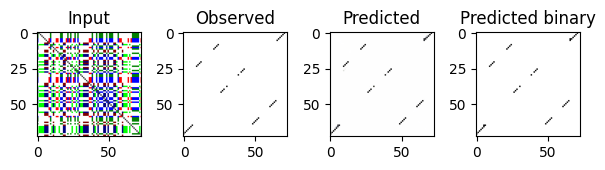

Epoch [1/5], Loss: 0.0043, Validation: 0.0065


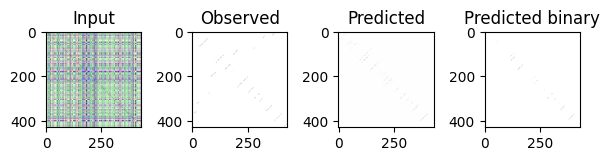

Epoch [2/5], Loss: 0.0022, Validation: 0.0061


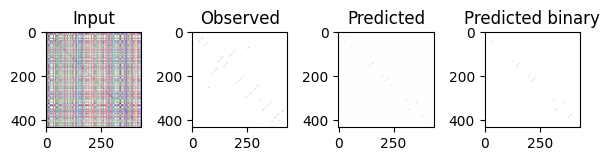

Epoch [3/5], Loss: 0.0021, Validation: 0.0766


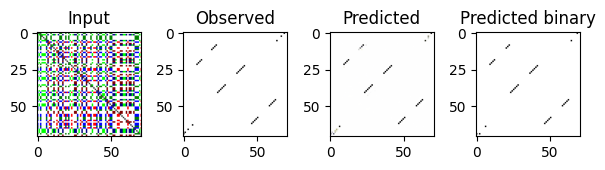

Epoch [4/5], Loss: 0.0016, Validation: 0.007


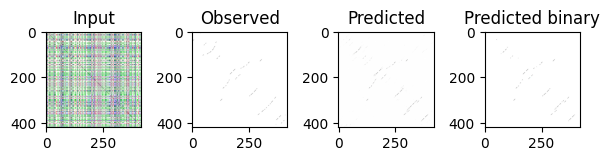

Epoch [5/5], Loss: 0.0013, Validation: 0.0405


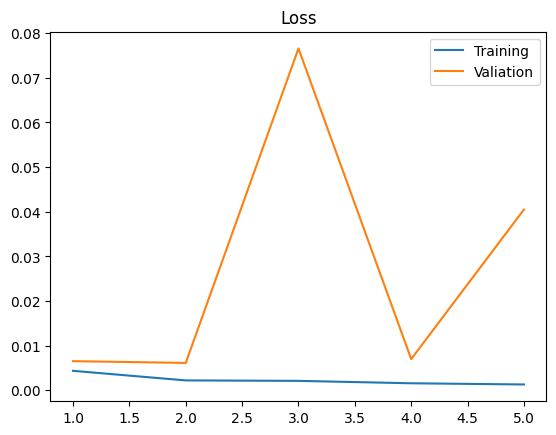

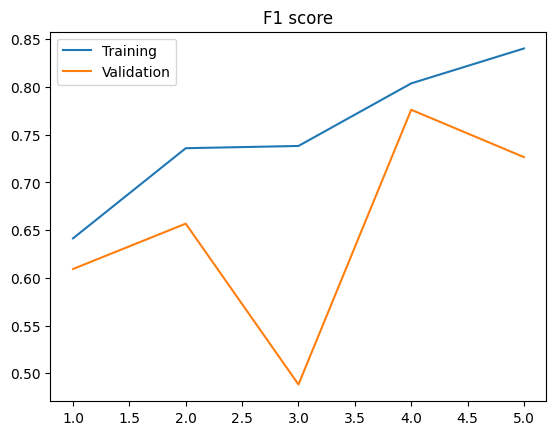

Finished training


In [ ]:
#Baseline
%matplotlib inline

model_unet = RNA_Unet().cuda()
summary(model_unet, input_size=(4, 201, 201))

fit_model(model_unet, train_dataset, validation_dataset)

print("Finished training")

In [ ]:
def plot_filters(layer, n_columns = 8):
    """
    args:
    layer: Layer from the neural network that contains a kernel to be visualized, e.g., model_unet.e11
    n_columns: Number of columns in the subplot, default 8
    """
    # Accessing weights
    filters = layer.weight.data

    # Normalize filters
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    # Visualize filters
    n_filters = filters.shape[0]
    n_cols = n_columns
    n_rows = n_filters // n_cols + (n_filters % n_cols > 0)

    plt.figure(figsize=(20,17))
    for i in range(n_filters):
        ax = plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(filters[i][0].cpu().numpy())
        plt.axis('off')
    plt.show()

filters_e21 = model_unet.e21.weight.data
filter_plot(filters_e21)

def plot_activations(activation_layer, n_columns = 8):
    """
    Requires that the activation layer has been explicitly returned by the neural network
    args:
    activation_layer: Layer that contains an activation to be visualized, e.g. xe11
    """
    for layer in activation_layer:
        n_layers = layer.shape[1]
        n_cols = n_columns
        n_rows = n_layers // n_cols + (n_filters % n_cols > 0)
        plt.figure(figsize=(20,17))
        for i in range(n_layers):
            ax = plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(layer[i][0].cpu().detach().numpy())
            plt.axis('off')
        plt.show()

activations = model_unet.activations
plot_activations(activations)

# Experiments

## Test different loss functions

In [ ]:
def plot_f1_curves(training_scores, validation_scores, output_file = None):
    colors = mpl.colormaps["tab10"].colors
    fig, ax = plt.subplots(constrained_layout=True, figsize = (10, 6))

    loss_names = list(training_losses.keys())

    handles = []

    for index, loss_name in enumerate(loss_names):
      x = [i for i in range(1, len(training_scores[loss_name])+1)]
      scatter_train = ax.scatter(x=x, y=training_scores[loss_name], marker="o", color=colors[index])
      scatter_valid = ax.scatter(x=x, y=validation_scores[loss_name], marker="x", color=colors[index])

      # Create line plots for training and validation
      line_train, = ax.plot(x, training_scores[loss_name], linestyle="-", color=colors[index])
      line_valid, = ax.plot(x, validation_scores[loss_name], linestyle="--", color=colors[index])

      #Add handles for legend
      handles.append(Line2D([0], [0], color = colors[index], linestyle = "-", marker = "o", label = f"Training {loss_name}"))
      handles.append(Line2D([0], [0], color = colors[index], linestyle = "--", marker = "x", label = f"Validation {loss_name}"))


    ax.set_title("Training and Validation f1 scores for Different Loss Functions", size=16)
    ax.set_xlabel("Epochs", size = 11)
    ax.set_ylabel("f1 score", size = 11)
    ax.legend(handles = handles, loc = 'upper left', bbox_to_anchor = (1.01, 1))

    if output_file:
      plt.savefig(output_file)

    plt.show()

def test_different_losses(loss_functions):
  training_scores = {}
  validation_scores = {}

  for loss_name, loss_fn in loss_functions.items():
    model = RNA_Unet().cuda() #Define untrained model
    print(f"Training with {loss_name}...")
    #Train model with given loss function
    _, train_f1, _, valid_f1, _ = fit_model(
        model,
        train_dataset,
        validation_dataset,
        loss_func=loss_fn,
        epochs=8,
        plots = False
    )
    training_scores[loss_name] = train_f1
    validation_scores[loss_name] = valid_f1
    print(f"Finished training {loss_name}\n")

  return training_scores, validation_scores

Training with BCE...


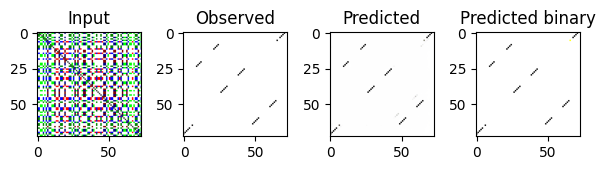

Epoch [1/2], Loss: 0.0044, Validation: 0.007


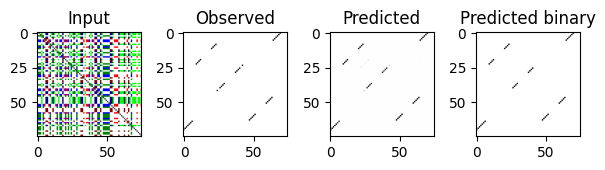

Epoch [2/2], Loss: 0.0016, Validation: 0.0042
Finished training BCE

Training with Weighted BCE...


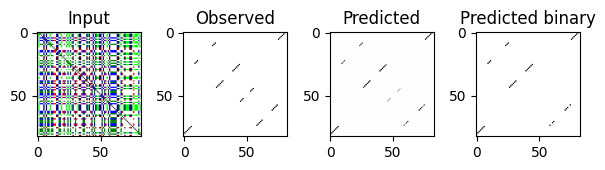

Epoch [1/2], Loss: 0.004, Validation: 0.0061


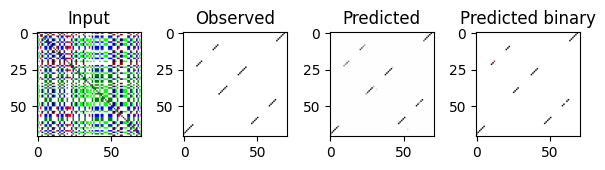

Epoch [2/2], Loss: 0.002, Validation: 0.0212
Finished training Weighted BCE

Training with Focal Loss...


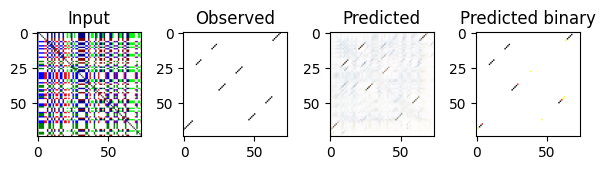

Epoch [1/2], Loss: 0.0018, Validation: 0.0054


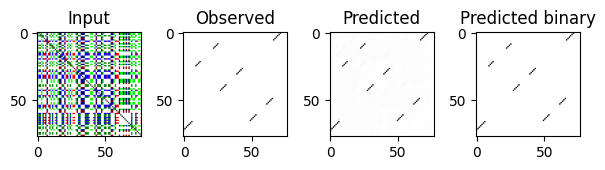

Epoch [2/2], Loss: 0.0005, Validation: 0.0011
Finished training Focal Loss



In [ ]:
# Define your train_dataset and validation_dataset here
train_dataset = ImageToImageDataset(train_input_dir, train_output_dir, input_transform = dataTransformer, output_transform = dataTransformer)
validation_dataset = ImageToImageDataset(val_input_dir, val_output_dir, input_transform = dataTransformer, output_transform = dataTransformer)


#Define loss functions
loss_functions = {"BCE": F.binary_cross_entropy,
    "MSE": mse_loss,
    "DICE Loss": dice_loss,
    "Asymmetric Loss": asymmetric_loss,
}

training_scores, validation_scores = test_different_losses(loss_functions)

#Save to csv files
pd.DataFrame([training_scores]).to_csv('/content/drive/MyDrive/loss_experiment_training.csv')
pd.DataFrame([validation_scores]).to_csv('/content/drive/MyDrive/loss_experiment_validation.csv')

plot_f1_curves(training_scores, validation_scores, output_file = '/content/drive/MyDrive/loss_experiment.png')

### Testing other changes

In [ ]:
def plot_loss_curves(training_losses, validation_losses, output_file = None):
    colors = mpl.colormaps["tab10"].colors
    fig, ax = plt.subplots(constrained_layout=True, figsize = (10, 6))

    model_names = list(training_losses.keys())

    handles = []

    for index, model_name in enumerate(model_names):
      x = [i for i in range(1, len(training_losses[model_name])+1)]
      scatter_train = ax.scatter(x=x, y=training_losses[model_name], marker="o", color=colors[index])
      scatter_valid = ax.scatter(x=x, y=validation_losses[model_name], marker="x", color=colors[index])

      # Create line plots for training and validation
      line_train, = ax.plot(x, training_losses[model_name], linestyle="-", color=colors[index])
      line_valid, = ax.plot(x, validation_losses[model_name], linestyle="--", color=colors[index])

      #Add handles for legend
      handles.append(Line2D([0], [0], color = colors[index], linestyle = "-", marker = "o", label = f"Training {model_name}"))
      handles.append(Line2D([0], [0], color = colors[index], linestyle = "--", marker = "x", label = f"Validation {model_name}"))


    ax.set_title("Training and Validation Loss for Different Model Modifications", size=16)
    ax.set_xlabel("Epochs", size = 11)
    ax.set_ylabel("Loss", size = 11)
    ax.legend(handles = handles, loc = 'upper left', bbox_to_anchor = (1.01, 1))

    if output_file:
      plt.savefig(output_file)

    plt.show()

def test_different_models(models):
  training_losses = {}
  validation_losses = {}

  for model_name, model_info in models.items():
    print(f"Training with {model_name}...")
    #Train model with given loss function
    train_loss, _, valid_loss, _, _ = fit_model(
        model_info[0],
        model_info[1],
        model_info[2],
        epochs=8,
        plots = False
    )
    training_losses[model_name] = train_loss
    validation_losses[model_name] = valid_loss
    print(f"Finished training {model_name}\n")

  return training_losses, validation_losses

Training with Baseline...


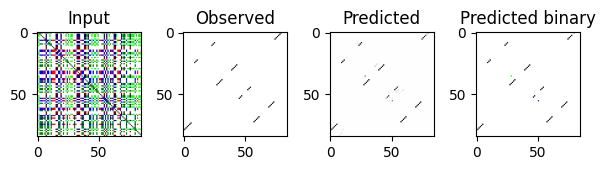

Epoch [1/5], Loss: 0.004, Validation: 0.0055


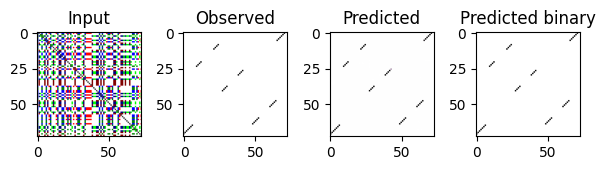

Epoch [2/5], Loss: 0.0016, Validation: 0.2192


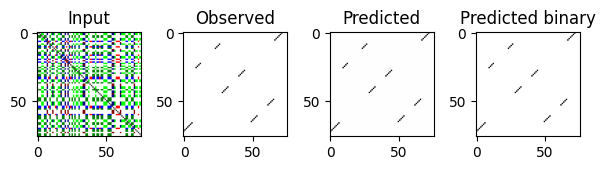

Epoch [3/5], Loss: 0.0011, Validation: 2.6736


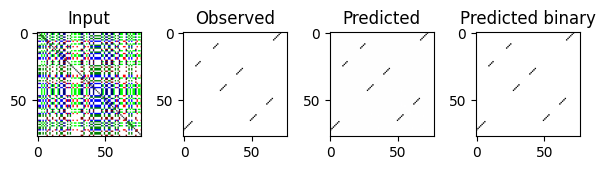

Epoch [4/5], Loss: 0.0009, Validation: 9.6569


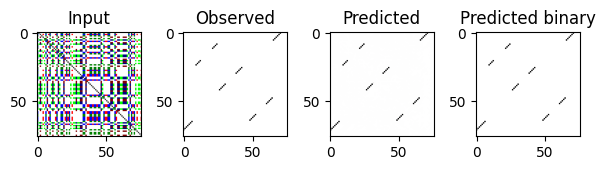

Epoch [5/5], Loss: 0.0006, Validation: 0.6506
Finished training Baseline

Training with leaky_ReLU...


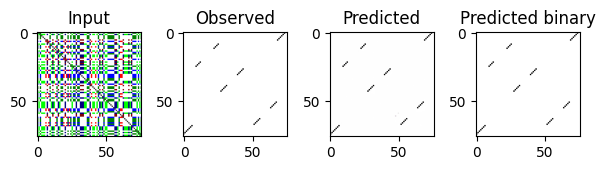

Epoch [1/5], Loss: 0.0041, Validation: 0.0031


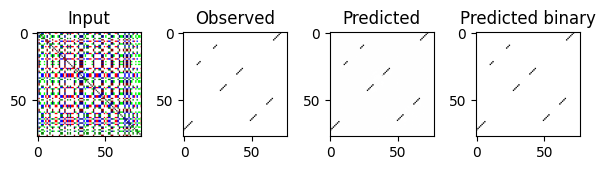

Epoch [2/5], Loss: 0.0016, Validation: 0.003


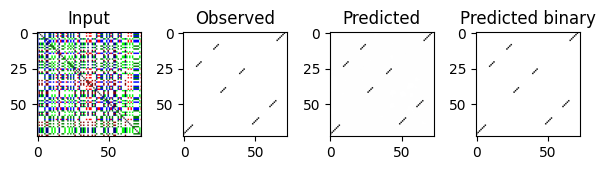

Epoch [3/5], Loss: 0.001, Validation: 0.0047


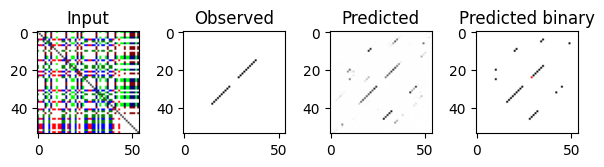

Epoch [4/5], Loss: 0.0008, Validation: 0.0149


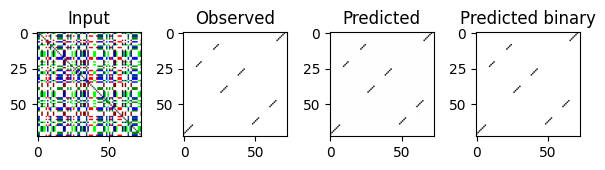

Epoch [5/5], Loss: 0.0006, Validation: 0.0012
Finished training leaky_ReLU

Training with 1 output channel...


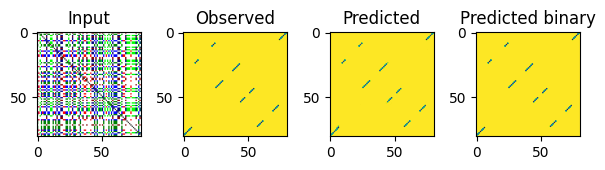

Epoch [1/5], Loss: 0.0077, Validation: 0.0275


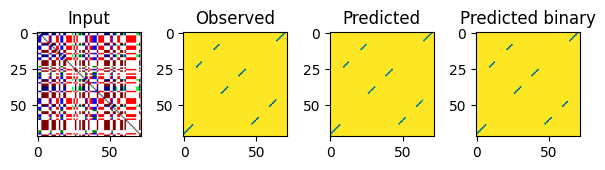

Epoch [2/5], Loss: 0.0054, Validation: 2.3306


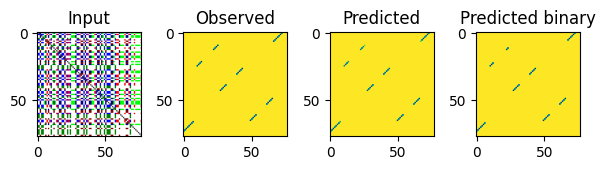

Epoch [3/5], Loss: 0.0056, Validation: 0.2195


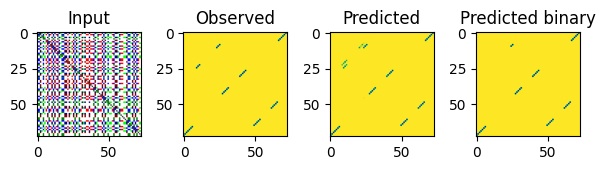

Epoch [4/5], Loss: 0.005, Validation: 0.3996


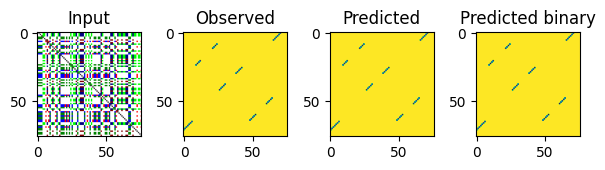

Epoch [5/5], Loss: 0.0048, Validation: 0.3423
Finished training 1 output channel

Training with Global average pooling...


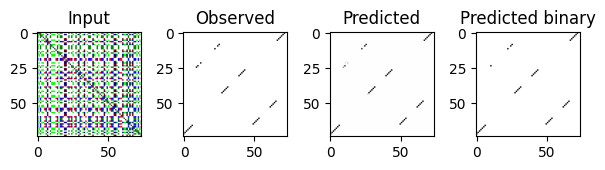

Epoch [1/5], Loss: 0.0038, Validation: 0.0019


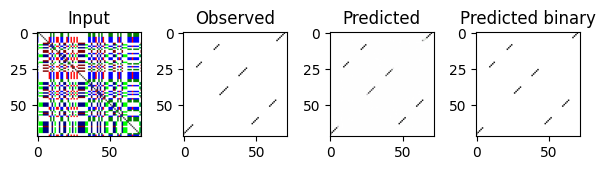

Epoch [2/5], Loss: 0.0014, Validation: 3.1273


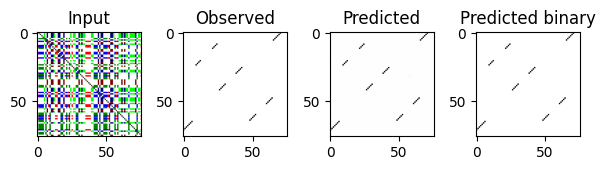

Epoch [3/5], Loss: 0.0011, Validation: 1.015


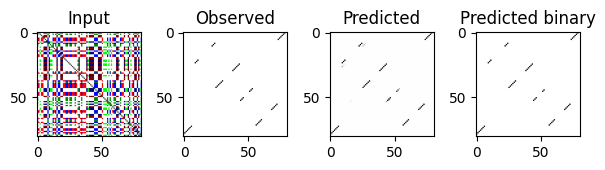

Epoch [4/5], Loss: 0.0007, Validation: 1.4641


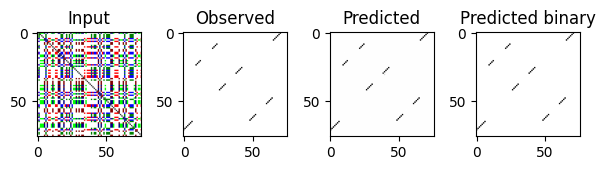

Epoch [5/5], Loss: 0.0007, Validation: 0.7098
Finished training Global average pooling

Training with Max pooling...


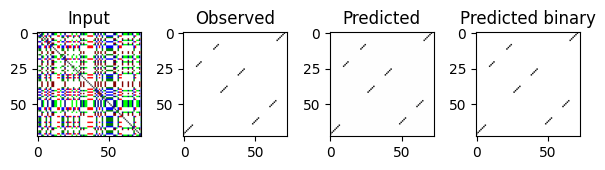

Epoch [1/5], Loss: 0.0038, Validation: 0.0093


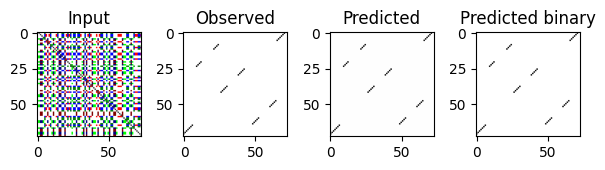

Epoch [2/5], Loss: 0.0013, Validation: 0.0666


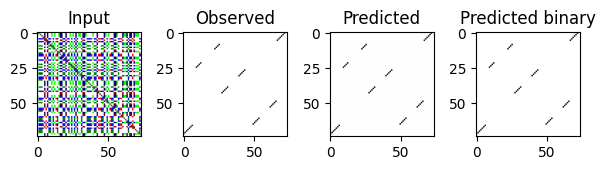

Epoch [3/5], Loss: 0.0009, Validation: 2.524


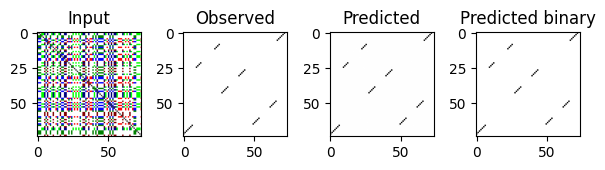

Epoch [4/5], Loss: 0.0007, Validation: 1.8469


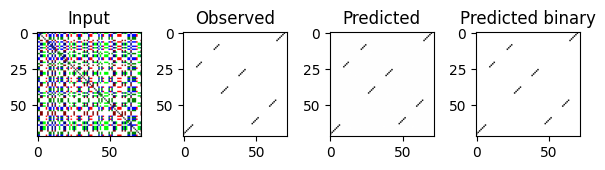

Epoch [5/5], Loss: 0.0005, Validation: 41.3539
Finished training Max pooling



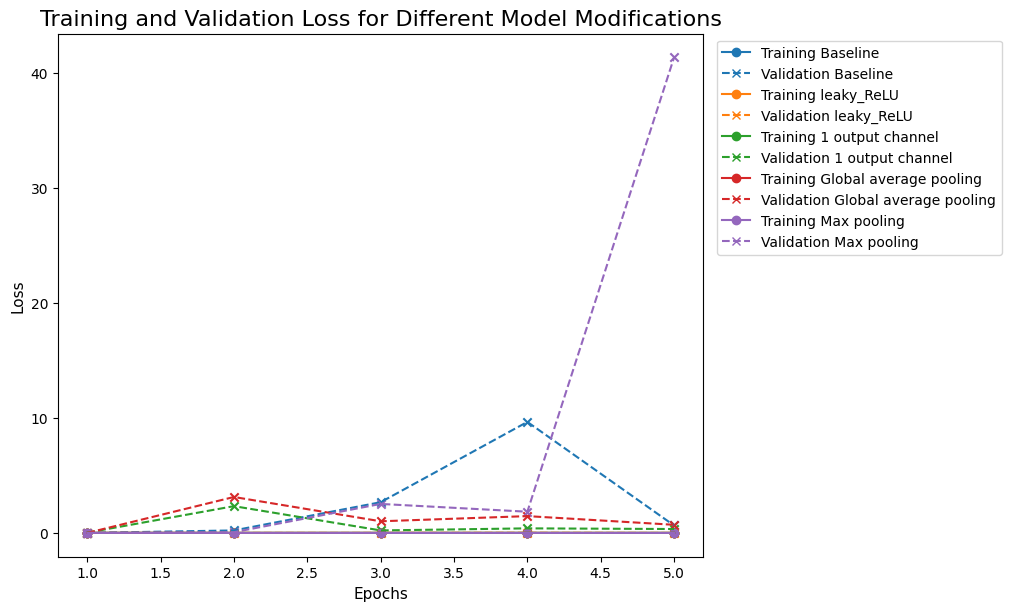

In [ ]:
models = {"Baseline": [RNA_Unet(channels=64, in_channels=4, output_channels=4, activation = F.relu, pooling = nn.Conv2d).cuda(), ImageToImageDataset(train_input_dir, train_output_dir, input_transform = dataTransformer, output_transform = dataTransformer), ImageToImageDataset(val_input_dir, val_output_dir, input_transform = dataTransformer, output_transform = dataTransformer)],
          "leaky_ReLU": [RNA_Unet(activation = F.leaky_relu).cuda(), ImageToImageDataset(train_input_dir, train_output_dir, input_transform = dataTransformer, output_transform = dataTransformer), ImageToImageDataset(val_input_dir, val_output_dir, input_transform = dataTransformer, output_transform = dataTransformer)],
          "1 output channel": [RNA_Unet(output_channels=1).cuda(), ImageToImageDataset(train_input_dir, train_output_dir, input_transform = dataTransformer, output_transform = grayscaleTransformer), ImageToImageDataset(val_input_dir, val_output_dir, input_transform = dataTransformer, output_transform = grayscaleTransformer)],
          "Global average pooling": [RNA_Unet(pooling=AveragePooling).cuda(), ImageToImageDataset(train_input_dir, train_output_dir, input_transform = dataTransformer, output_transform = dataTransformer), ImageToImageDataset(val_input_dir, val_output_dir, input_transform = dataTransformer, output_transform = dataTransformer)],
          "Max pooling": [RNA_Unet(pooling=MaxPooling).cuda(), ImageToImageDataset(train_input_dir, train_output_dir, input_transform = dataTransformer, output_transform = dataTransformer), ImageToImageDataset(val_input_dir, val_output_dir, input_transform = dataTransformer, output_transform = dataTransformer)]
}


training_losses, validation_losses = test_different_models(models)

pd.DataFrame([training_losses]).to_csv('/content/drive/MyDrive/model_experiment_training.csv')
pd.DataFrame([validation_losses]).to_csv('/content/drive/MyDrive/model_experiment_validation.csv')

plot_loss_curves(training_losses, validation_losses, output_file = '/content/drive/MyDrive/model_experiment.png')


### Distribution of data

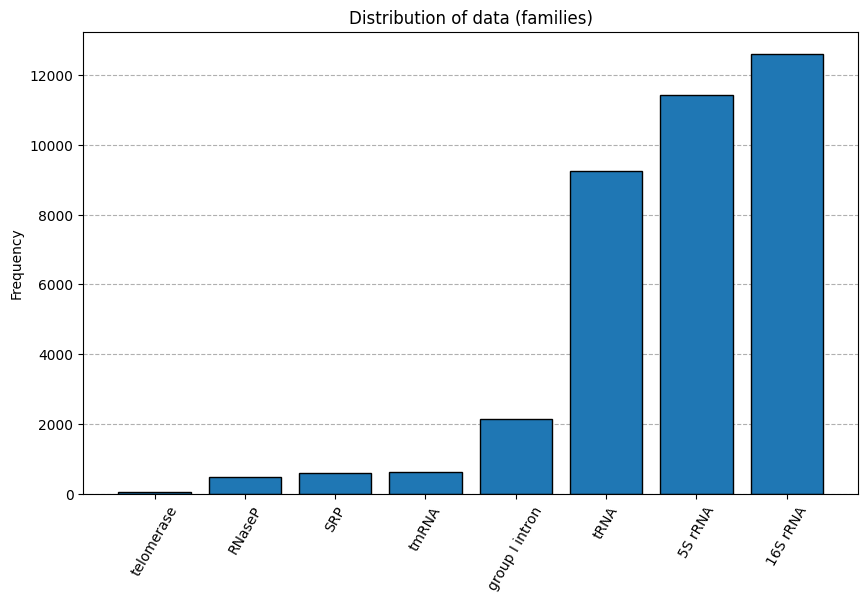

In [ ]:
def plot_families(ct_file, output_file = None):
  RNA_families = {}

  with open(ct_file, 'r') as file:
    for line in file:
      family = " ".join(line.split(os.sep)[4].split('_')[:-1])
      if family not in RNA_families:
        RNA_families[family] = 1
      else:
        RNA_families[family] += 1

  RNA_families = sorted(RNA_families.items(), key=lambda x:x[1])
  values = [f[1] for f in RNA_families]
  families = [f[0] for f in RNA_families]

  fig, ax = plt.subplots(figsize=(10,4))
  ax.bar(range(len(RNA_families)), values, tick_label = families, edgecolor = 'black')
  ax.grid(axis = 'y', linestyle = '--')
  ax.set_axisbelow(True)
  ax.tick_params(axis = 'x', labelrotation = 60)
  ax.set_ylabel("Frequency")
  ax.set_title('Distribution of data (families)')

  if output_file:
    plt.savefig(output_file)

  plt.show()


plot_families("ct_files.txt", output_file = '/content/drive/MyDrive/family_distribution.png')
plot_families("ct_files_no_5S.txt", output_file = '/content/drive/MyDrive/family_distribution_test.png');

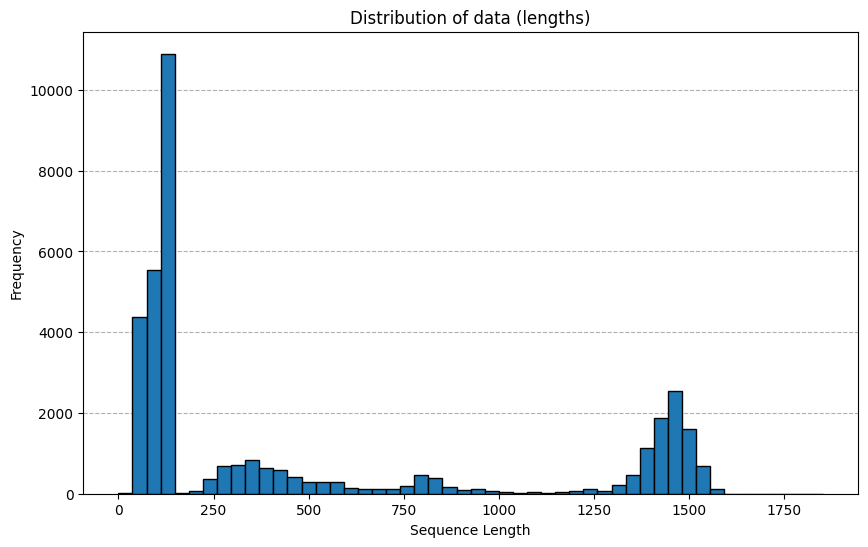

In [ ]:
def plot_len_histogram(input_file, output_file = None):
  # Takes a list of .ct file and produces a histogram of the distribution of lengths of sequences
  _lengths = list()

  for file in input_file:
    _seq, _ = read_ct(file)
    _lengths.append(len(_seq))

  plt.figure(figsize=(10,6))

  plt.hist(_lengths, bins=50, edgecolor='black')

  plt.title('Distribution of data (lengths)')
  plt.xlabel('Sequence Length')
  plt.ylabel('Frequency')

  plt.grid(axis = 'y', linestyle='--', zorder=0)

  plt.gca().set_axisbelow(True)

  if output_file:
    plt.savefig(output_file)

  plt.show()


plot_len_histogram(ct_files, output_file = '/content/drive/MyDrive/length_distribution.png')
plot_len_histogram(file_list, output_file = '/content/drive/MyDrive/length_distribution_test.png');